<!-- PELICAN_BEGIN_SUMMARY -->

[PyMC3](https://docs.pymc.io/index.html) is a great tool for doing Bayesian inference and parameter estimation. It has a load of [in-built probability distributions](https://docs.pymc.io/api/distributions.html) that you can use to set up priors and likelihood functions for your particular model. You can even create your own [custom distributions](https://docs.pymc.io/prob_dists.html#custom-distributions).

However, this is not necessarily that simple if you have a model function, or probability distribution, that, for example, relies on an external code that you have little/no control over (and may even be, for example, wrapped `C` code rather than Python). This can be problematic went you need to pass parameters set as PyMC3 distributions to these external functions; your external function probably wants you to pass it floating point numbers rather than PyMC3 distributions!

<!-- PELICAN_END_SUMMARY -->

```python
import pymc3 as pm:
from external_module import my_external_func  # your external function!

# set up your model
with pm.Model():
    # your external function takes two parameters, a and b, with Uniform priors
    a = pm.Uniform('a', lower=0., upper=1.)
    b = pm.Uniform('b', lower=0., upper=1.)
    
    m = my_external_func(a, b)  # <--- this is not going to work!
```

Another issue is that if you want to be able to use the gradient-based step samplers like [NUTS](https://docs.pymc.io/api/inference.html#module-pymc3.step_methods.hmc.nuts) and [Hamiltonian Monte Carlo (HMC)](https://docs.pymc.io/api/inference.html#hamiltonian-monte-carlo) then your model/likelihood needs a gradient to be defined. If you have a model that is defined as a set of Theano operators then this is no problem - internally it will be able to do automatic differentiation - but if yor model is essentially a "black box" then you won't necessarily know what the gradients are.

Defining a model/likelihood that PyMC3 can use that calls your "black box" function is possible, but it relies on creating a [custom Theano Op](https://docs.pymc.io/advanced_theano.html#writing-custom-theano-ops). There are many [threads](https://discourse.pymc.io/search?q=as_op) on the PyMC3 [discussion forum](https://discourse.pymc.io/) about this (e.g., [here](https://discourse.pymc.io/t/custom-theano-op-to-do-numerical-integration/734), [here](https://discourse.pymc.io/t/using-pm-densitydist-and-customized-likelihood-with-a-black-box-function/1760) and [here](https://discourse.pymc.io/t/connecting-pymc3-to-external-code-help-with-understanding-theano-custom-ops/670)), but I couldn't find any clear example that described doing what I mention above. So, thanks to a very nice example [sent](https://discourse.pymc.io/t/connecting-pymc3-to-external-code-help-with-understanding-theano-custom-ops/670/7?u=mattpitkin) to me by [Jørgen Midtbø](https://github.com/jorgenem/), I have created what I hope is a clear description. Do let [me](https://twitter.com/matt_pitkin) know if you have any questions/spot any mistakes.

In the examples below, I'm going to create a very simple model and log-likelihood function in [Cython](http://cython.org/). I use Cython just as an example to show what you might need if calling external `C` codes, but you could in fact be using pure Python codes. The log-likelihood function I use is actually just a [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), so this is obviously overkill (and I'll compare it to doing the same thing purely with PyMC3 distributions), but should provide a simple to follow demonstration.

In [1]:
%matplotlib inline
%load_ext Cython

import numpy as np
import pymc3 as pm
import theano
import theano.tensor as tt

# for reproducibility here's some version info for modules used in this notebook
import platform
import cython
import IPython
import matplotlib
import emcee
import corner
import os
print("Python version:     {}".format(platform.python_version()))
print("IPython version:    {}".format(IPython.__version__))
print("Cython version:     {}".format(cython.__version__))
print("GSL version:        {}".format(os.popen('gsl-config --version').read().strip()))
print("Numpy version:      {}".format(np.__version__))
print("Theano version:     {}".format(theano.__version__))
print("PyMC3 version:      {}".format(pm.__version__))
print("Matplotlib version: {}".format(matplotlib.__version__))
print("emcee version:      {}".format(emcee.__version__))
print("corner version:     {}".format(corner.__version__))

/home/matthew/.conda/envs/testing/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Python version:     3.6.6
IPython version:    6.5.0
Cython version:     0.28.5
GSL version:        2.1
Numpy version:      1.15.0
Theano version:     1.0.2
PyMC3 version:      3.5
Matplotlib version: 2.2.3
emcee version:      2.2.1
corner version:     2.0.1


First, I'll define my "_super-complicated_"&trade; model (a straight line!), which is parameterised by two variables (a gradient `m` and a y-intercept `c`) and calculated at a vector of points `x`. I'll define the model in [Cython](http://cython.org/) and call [GSL](https://www.gnu.org/software/gsl/) functions just to show that you could be calling some other `C` library that you need. In this case, the model parameters are all packed into a list/array/tuple called `theta`.

I'll also define my "_really-complicated_"&trade; log-likelihood function (a Normal log-likelihood that ignores the normalisation), which takes in the list/array/tuple of model parameter values `theta`, the points at which to calculate the model `x`, the vector of "observed" data points `data`, and the standard deviation of the noise in the data `sigma`.

In [2]:
%%cython -I/usr/include -L/usr/lib/x86_64-linux-gnu -lgsl -lgslcblas -lm

import cython
cimport cython

import numpy as np
cimport numpy as np

### STUFF FOR USING GSL (FEEL FREE TO IGNORE!) ###

# declare GSL vector structure and functions
cdef extern from "gsl/gsl_block.h":
    cdef struct gsl_block:
        size_t size
        double * data

cdef extern from "gsl/gsl_vector.h":
    cdef struct gsl_vector:
        size_t size
        size_t stride
        double * data
        gsl_block * block
        int owner

    ctypedef struct gsl_vector_view:
        gsl_vector vector

    int gsl_vector_scale (gsl_vector * a, const double x) nogil
    int gsl_vector_add_constant (gsl_vector * a, const double x) nogil
    gsl_vector_view gsl_vector_view_array (double * base, size_t n) nogil

###################################################


# define your super-complicated model that uses load of external codes
cpdef my_model(theta, np.ndarray[np.float64_t, ndim=1] x):
    """
    A straight line!

    Note:
        This function could simply be:

            m, c = thetha
            return m*x + x

        but I've made it more complicated for demonstration purposes
    """
    m, c = theta  # unpack line gradient and y-intercept

    cdef size_t length = len(x)  # length of x

    cdef np.ndarray line = np.copy(x)  # make copy of x vector
    cdef gsl_vector_view lineview      # create a view of the vector
    lineview = gsl_vector_view_array(<double *>line.data, length) 

    # multiply x by m
    gsl_vector_scale(&lineview.vector, <double>m)

    # add c
    gsl_vector_add_constant(&lineview.vector, <double>c)

    # return the numpy array
    return line


# define your really-complicated likelihood function that uses loads of external codes
cpdef my_loglike(theta, np.ndarray[np.float64_t, ndim=1] x,
                 np.ndarray[np.float64_t, ndim=1] data, sigma):
    """
    A Gaussian log-likelihood function for a model with parameters given in theta
    """

    model = my_model(theta, x)

    return -(0.5/sigma**2)*np.sum((data - model)**2)

Now, as things are, if we wanted to sample from this log-likelihood function, using certain prior distributions for the model parameters (gradient and y-intercept) using PyMC3 we might try something like this (using a [PyMC3 `DensityDist`](https://docs.pymc.io/prob_dists.html#custom-distributions)):

```python
import pymc3 as pm

# create/read in our "data" (I'll show this in the real example below)
x = ...
sigma = ...
data = ...

with pm.Model():
    # set priors on model gradient and y-intercept
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # create custom distribution 
    pm.DensityDist('likelihood', my_loglike,
                   observed={'theta': (m, c), 'x': x, 'data': data, 'sigma': sigma})
    
    # sample from the distribution
    trace = pm.sample(1000)
```

But, this will give an error like:

```
ValueError: setting an array element with a sequence.
```

This is because `m` and `c` are Theano tensor-type objects.

So, what we actually need to do is create a [Theano Op](http://deeplearning.net/software/theano/extending/extending_theano.html). This will be a new class that wraps our log-likelihood function (or just our model function, if that is all that is required) into something that can take in Theano tensor objects, but internally can cast them as floating point values that can be passed to our log-likelihood function. I will do this below, initially without defining a [`grad()` method](http://deeplearning.net/software/theano/extending/op.html#grad) for the Op.

In [3]:
# define a theano Op for our likelihood function
class LogLike(tt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """
    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)
    
    def __init__(self, loglike, data, x, sigma):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables
 
        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

Now, let's use this Op to repeat the example shown above. To do this I'll create some data containing a straight line with additive Gaussian noise (with a mean of zero and a standard deviation of `sigma`). I'll set uniform prior distributions on the gradient and y-intercept. As I've not set the `grad()` method of the Op PyMC3 will not be able to use the gradient-based samplers, so will fall back to using the [Slice](https://docs.pymc.io/api/inference.html#module-pymc3.step_methods.slicer) sampler.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS failed. Falling back to elementwise auto-assignment.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [c]
>Slice: [m]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1904.47draws/s]
/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


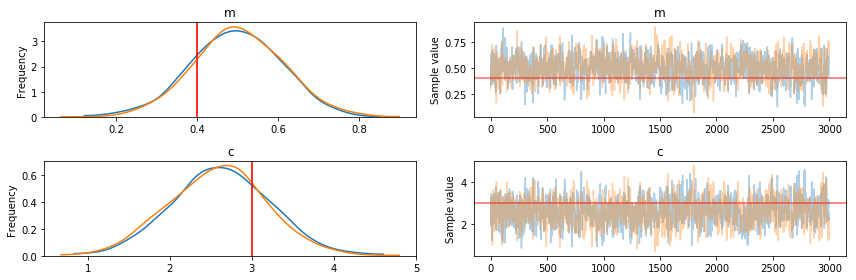

In [4]:
# set up our data
N = 10  # number of data points
sigma = 1.  # standard deviation of noise
x = np.linspace(0., 9., N)

mtrue = 0.4  # true gradient
ctrue = 3.   # true y-intercept

truemodel = my_model([mtrue, ctrue], x)

# make data
data = sigma*np.random.randn(N) + truemodel

ndraws = 3000  # number of draws from the distribution
nburn = 1000   # number of "burn-in points" (which we'll discard)

# create our Op
logl = LogLike(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a DensityDist (use a lamdba function to "call" the Op)
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})
    
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

# plot the traces
_ = pm.traceplot(trace, lines={'m': mtrue, 'c': ctrue})

# put the chains in an array (for later!)
samples_pymc3 = np.vstack((trace['m'], trace['c'])).T

What if we wanted to use NUTS or HMC? If we knew the analytical derivatives of the model/likelihood function then we could add a [`grad()` method](http://deeplearning.net/software/theano/extending/op.html#grad) to the Op using that analytical form.

But, what if we don't know the analytical form. If our model/likelihood is purely Python and made up of standard maths operators and Numpy functions, then the [autograd](https://github.com/HIPS/autograd) module could potentially be used to find gradients (also, see [here](https://github.com/ActiveState/code/blob/master/recipes/Python/580610_Auto_differentiation/recipe-580610.py) for a nice Python example of automatic differentiation). But, if our model/likelihood truely is a "black box" then we can just use the good-old-fashioned [finite difference](https://en.wikipedia.org/wiki/Finite_difference) to find the gradients - this can be slow, especially if there are a large number of variables, or the model takes a long time to evaluate. Below, I've written a function that uses finite difference (the central difference) to find gradients - it uses an iterative method with successively smaller step sizes to check that the gradient converges. But, you could do something far simpler and just use, for example, the SciPy [`approx_fprime`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.approx_fprime.html) function.

In [5]:
import warnings

def gradients(vals, func, releps=1e-3, abseps=None, mineps=1e-9, reltol=1e-3,
                epsscale=0.5):
    """
    Calculate the partial derivatives of a function at a set of values. The
    derivatives are calculated using the central difference, using an iterative
    method to check that the values converge as step size decreases.

    Parameters
    ----------
    vals: array_like
        A set of values, that are passed to a function, at which to calculate
        the gradient of that function
    func:
        A function that takes in an array of values.
    releps: float, array_like, 1e-3
        The initial relative step size for calculating the derivative.
    abseps: float, array_like, None
        The initial absolute step size for calculating the derivative.
        This overrides `releps` if set.
        `releps` is set then that is used.
    mineps: float, 1e-9
        The minimum relative step size at which to stop iterations if no
        convergence is achieved.
    epsscale: float, 0.5
        The factor by which releps if scaled in each iteration.
        
    Returns
    -------
    grads: array_like
        An array of gradients for each non-fixed value.
    """

    grads = np.zeros(len(vals))

    # maximum number of times the gradient can change sign
    flipflopmax = 10.

    # set steps
    if abseps is None:
        if isinstance(releps, float):
            eps = np.abs(vals)*releps
            eps[eps == 0.] = releps  # if any values are zero set eps to releps
            teps = releps*np.ones(len(vals))
        elif isinstance(releps, (list, np.ndarray)):
            if len(releps) != len(vals):
                raise ValueError("Problem with input relative step sizes")
            eps = np.multiply(np.abs(vals), releps)
            eps[eps == 0.] = np.array(releps)[eps == 0.]
            teps = releps
        else:
            raise RuntimeError("Relative step sizes are not a recognised type!")
    else:
        if isinstance(abseps, float):
            eps = abseps*np.ones(len(vals))
        elif isinstance(abseps, (list, np.ndarray)):
            if len(abseps) != len(vals):
                raise ValueError("Problem with input absolute step sizes")
            eps = np.array(abseps)
        else:
            raise RuntimeError("Absolute step sizes are not a recognised type!")
        teps = eps

    # for each value in vals calculate the gradient
    count = 0
    for i in range(len(vals)):
        # initial parameter diffs
        leps = eps[i]
        cureps = teps[i]

        flipflop = 0

        # get central finite difference
        fvals = np.copy(vals)
        bvals = np.copy(vals)

        # central difference
        fvals[i] += 0.5*leps  # change forwards distance to half eps
        bvals[i] -= 0.5*leps  # change backwards distance to half eps
        cdiff = (func(fvals)-func(bvals))/leps

        while 1:
            fvals[i] -= 0.5*leps  # remove old step
            bvals[i] += 0.5*leps

            # change the difference by a factor of two
            cureps *= epsscale
            if cureps < mineps or flipflop > flipflopmax:
                # if no convergence set flat derivative (TODO: check if there is a better thing to do instead)
                warnings.warn("Derivative calculation did not converge: setting flat derivative.")
                grads[count] = 0.
                break
            leps *= epsscale

            # central difference
            fvals[i] += 0.5*leps  # change forwards distance to half eps
            bvals[i] -= 0.5*leps  # change backwards distance to half eps
            cdiffnew = (func(fvals)-func(bvals))/leps

            if cdiffnew == cdiff:
                grads[count] = cdiff
                break

            # check whether previous diff and current diff are the same within reltol
            rat = (cdiff/cdiffnew)
            if np.isfinite(rat) and rat > 0.:
                # gradient has not changed sign
                if np.abs(1.-rat) < reltol:
                    grads[count] = cdiffnew
                    break
                else:
                    cdiff = cdiffnew
                    continue
            else:
                cdiff = cdiffnew
                flipflop += 1
                continue

        count += 1

    return grads

So, now we can just redefine our Op with a `grad()` method, right?

It's not quite so simple! The `grad()` method itself requires that its inputs are Theano tensor variables, whereas our `gradients` function above, like our `my_loglike` function, wants a list of floating point values. So, we need to define another Op that calculates the gradients. Below, I define a new version of the `LogLike` Op, called `LogLikeWithGrad` this time, that has a `grad()` method. This is followed by anothor Op called `LogLikeGrad` that, when called with a vector of Theano tensor variables, returns another vector of values that are the gradients (i.e., the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)) of our log-likelihood function at those values. Note that the `grad()` method itself does not return the gradients directly, but instead returns the [Jacobian](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)-vector product (you can hopefully just copy what I've done and not worry about what this means too much!).

In [6]:
# define a theano Op for our likelihood function
class LogLikeWithGrad(tt.Op):

    itypes = [tt.dvector] # expects a vector of parameter values when called
    otypes = [tt.dscalar] # outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.
        
        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

        # initialise the gradient Op (below)
        self.logpgrad = LogLikeGrad(self.likelihood, self.data, self.x, self.sigma)

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        theta, = inputs  # this will contain my variables
 
        # call the log-likelihood function
        logl = self.likelihood(theta, self.x, self.data, self.sigma)

        outputs[0][0] = np.array(logl) # output the log-likelihood

    def grad(self, inputs, g):
        # the method that calculates the gradients - it actually returns the
        # vector-Jacobian product - g[0] is a vector of parameter values 
        theta, = inputs  # our parameters 
        return [g[0]*self.logpgrad(theta)]


class LogLikeGrad(tt.Op):

    """
    This Op will be called with a vector of values and also return a vector of
    values - the gradients in each dimension.
    """
    itypes = [tt.dvector]
    otypes = [tt.dvector]

    def __init__(self, loglike, data, x, sigma):
        """
        Initialise with various things that the function requires. Below
        are the things that are needed in this particular example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        data:
            The "observed" data that our log-likelihood function takes in
        x:
            The dependent variable (aka 'x') that our model requires
        sigma:
            The noise standard deviation that out function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        theta, = inputs

        # define version of likelihood function to pass to derivative function
        def lnlike(values):
            return self.likelihood(values, self.x, self.data, self.sigma)

        # calculate gradients
        grads = gradients(theta, lnlike)

        outputs[0][0] = grads

Now, let's re-run PyMC3 with our new "grad"-ed Op. This time it will be able to automatically use NUTS.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:10<00:00, 792.21draws/s]
/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The number of effective samples is smaller than 25% for some parameters.


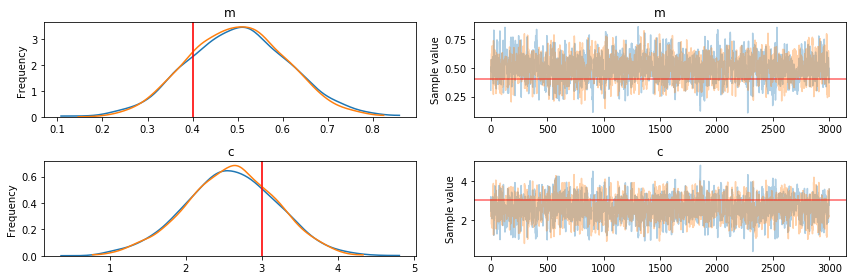

In [7]:
# create our Op
logl = LogLikeWithGrad(my_loglike, data, x, sigma)

# use PyMC3 to sampler from log-likelihood
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])
    
    # use a DensityDist
    pm.DensityDist('likelihood', lambda v: logl(v), observed={'v': theta})
    
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

# plot the traces
_ = pm.traceplot(trace, lines={'m': mtrue, 'c': ctrue})

# put the chains in an array (for later!)
samples_pymc3_2 = np.vstack((trace['m'], trace['c'])).T

Now, finally, just to check things actually worked as we might expect, let's do the same thing purely using PyMC3 distributions (because in this simple example we can!)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [c, m]
Sampling 2 chains: 100%|██████████| 8000/8000 [00:04<00:00, 1782.41draws/s]
/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


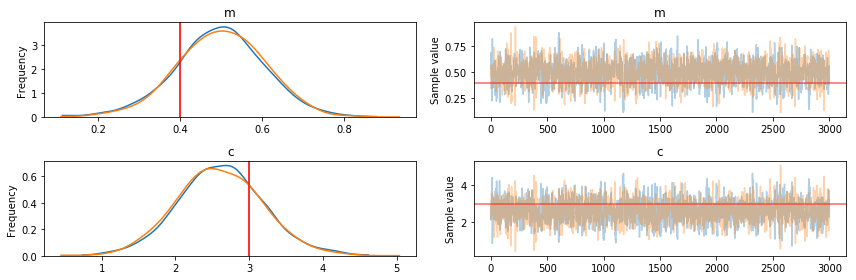

In [8]:
with pm.Model():
    # uniform priors on m and c
    m = pm.Uniform('m', lower=-10., upper=10.)
    c = pm.Uniform('c', lower=-10., upper=10.)

    # convert m and c to a tensor vector
    theta = tt.as_tensor_variable([m, c])

    # use a Normal distribution
    pm.Normal('likelihood', mu=(m*x + c), sd = sigma, observed=data)
    
    trace = pm.sample(ndraws, tune=nburn, discard_tuned_samples=True)

# plot the traces
_ = pm.traceplot(trace, lines={'m': mtrue, 'c': ctrue})

# put the chains in an array (for later!)
samples_pymc3_3 = np.vstack((trace['m'], trace['c'])).T

To check that they match let's plot all the examples together and also find the autocorrelation lengths.

/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:158: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.fft(a, n, axis)
/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/emcee/autocorr.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acf = np.fft.ifft(f * np.conjugate(f), axis=axis)[m].real
/home/matthew/.conda/envs/testing/lib/python3.6/site-packages/emcee/autocorr.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(se

Auto-correlation length (Theanp Op (no grad)): 7
Auto-correlation length (Theano Op (with grad)): 4
Auto-correlation length (Pure PyMC3): 3


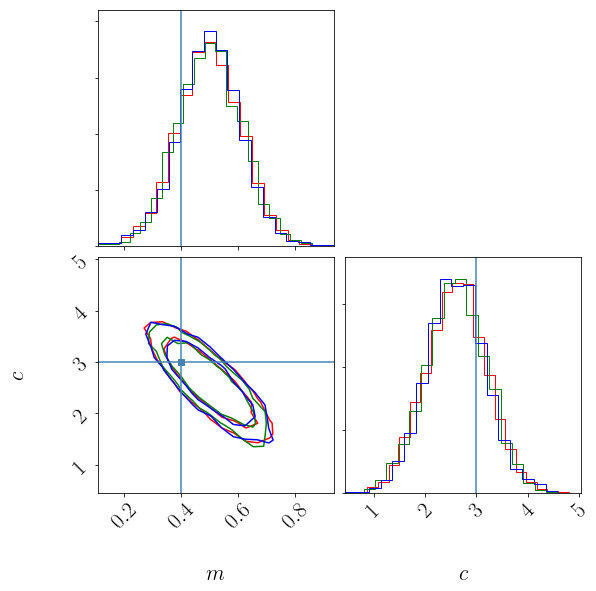

In [9]:
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['font.size'] = 22

hist2dkwargs = {'plot_datapoints': False,
                'plot_density': False,
                'levels': 1.0 - np.exp(-0.5 * np.arange(1.5, 2.1, 0.5) ** 2)} # roughly 1 and 2 sigma

colors = ['r', 'g', 'b']
labels = ['Theanp Op (no grad)', 'Theano Op (with grad)', 'Pure PyMC3']

for i, samples in enumerate([samples_pymc3, samples_pymc3_2, samples_pymc3_3]):
    # get maximum chain autocorrelartion length
    autocorrlen = int(np.max(emcee.autocorr.integrated_time(samples, c=3)));
    print('Auto-correlation length ({}): {}'.format(labels[i], autocorrlen))

    if i == 0:
        fig = corner.corner(samples, labels=[r"$m$", r"$c$"], color=colors[i],
                            hist_kwargs={'density': True}, **hist2dkwargs,
                            truths=[mtrue, ctrue])
    else:
        corner.corner(samples, color=colors[i], hist_kwargs={'density': True},
                      fig=fig, **hist2dkwargs)
        
fig.set_size_inches(9, 9)

The Jupyter notebook used to produce this page can be downloaded from [here](http://mattpitkin.github.io/samplers-demo/downloads/notebooks/PyMC3CustomExternalLikelihood.ipynb).